# Real Estate Prices Prediction

In [1]:
import datetime
import gc

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.metrics import r2_score as r2
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold

from lightgbm import LGBMRegressor

## 1. Загрузка данных

In [2]:
path_train = '../input/realestatepriceprediction/train.csv'
path_test = '../input/realestatepriceprediction/test.csv'

df = pd.read_csv(path_train)
X = df.drop('Price', axis=1)
y = df[['Price']]
X.set_index('Id', inplace=True)

X_final = pd.read_csv(path_test)
preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()
X_final.set_index('Id', inplace=True)

X['DistrictId'] = X['DistrictId'].astype(str)
X_final['DistrictId'] = X_final['DistrictId'].astype(str)

print('Строк в трейне:' ,  X.shape[0])
print('Строк в тесте', X_final.shape[0])

del df
gc.collect()

Строк в трейне: 10000
Строк в тесте 5000


0

## 2. Очистка данных

In [3]:
class FeatureImputer:
    """Заполнение пропусков и обработка выбросов"""
    
    def __init__(self):
        self.medians=None
        
    def fit(self, X):
        self.medians = X.median()
            
    def transform(self, X):
        
        # Обработка пропусков
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
    
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1

        # Обработка выборосов
    
        # Rooms
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        X.loc[X['Rooms'] == 0, 'Rooms'] = self.medians['Rooms']

        # Square 
        X.loc[X['Square'] > 350, 'Square'] = self.medians['Square']
        X.loc[X['Square'] < 10, 'Square'] = self.medians['Square']
        
        # LifeSquare 
        X.loc[X['LifeSquare'] >= 1000, 'LifeSquare'] = self.medians['LifeSquare']
        X.loc[(X['LifeSquare'] > 350), 'LifeSquare'] = self.medians['LifeSquare']
        X.loc[X['LifeSquare'] < 1, 'LifeSquare'] = self.medians['LifeSquare']
        X.loc[X['LifeSquare'] < 3, 'LifeSquare'] = self.medians['LifeSquare']
        
        # KitchenSquare
        X.loc[X['KitchenSquare'] >= 1000, 'KitchenSquare'] = self.medians['KitchenSquare']
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = self.medians['KitchenSquare']

        # HouseYear
        current_year = now = datetime.datetime.now().year
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = self.medians['HouseYear']
        
        X['Social_1_category'] = (X['Social_1'] // 10 * 10)
        X['Social_3_category'] = (X['Social_3'] // 10 * 10)
        X['Social_2_category'] = (X['Social_2'] // 10 * 10) 
        X['HouseFloor_category'] = (X['HouseFloor'] // 10 * 10)


        return X

In [4]:
imputer = FeatureImputer()

imputer.fit(X)

X = imputer.transform(X)
X_final = imputer.transform(X_final)

## 3. Генерация новых фич

In [5]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.binary_to_numbers = None
        self.DistrictId_counts = None
        
    def fit(self, X, y=None):
        X = X.copy()
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # District_objects_count
        district_count = X['DistrictId'].value_counts()
        district_count = district_count[district_count > 50]
        self.DistrictId_counts = dict(district_count)
        
        # Target encoding
        ## District
        df = X.copy()
        
        if y is None:
            return
        
        df = self.floor_to_cat(df)
        df = self.year_to_cat(df)
        df = self.house_floor_to_cat(df)
        df = self.ecology_to_cat(df)
        df = self.social1_to_cat(df)
        df = self.shops1_to_cat(df)
        
        df['Price'] = y.values

        df['DistrictId_popular'] = df['DistrictId'].copy()
        df.loc[~df['DistrictId_popular'].isin(district_count.keys().tolist())] = np.nan

        #median price by double groupping
        #(group_feture_1, group_feature_2, f1_merge_name)
        self.med_by_double_groupping_features = [
            ('DistrictId_popular', 'Rooms', 'DistrictId'),
            ('year_cat', 'floor_cat', 'year_cat'),
            ('DistrictId_popular', 'house_floor_cat', 'DistrictId'),
            ('DistrictId_popular', 'ecology_to_cat', 'DistrictId'),
            ('DistrictId_popular', 'social1_to_cat', 'DistrictId'),
            ('DistrictId_popular', 'shops1_to_cat', 'DistrictId')
        ]
        
        self.med_by_double_groupping_features_values = {
            item: df.groupby([item[0], item[1]], as_index=False).agg({'Price':'median'}).\
                rename(columns={'Price': 'med_price_by_' + item[0] + '_' + item[1], item[0]: item[2]})
            for item in self.med_by_double_groupping_features
        }
        
        #mean feature2 by groupping feature1
        self.mean_groupping_pairs = [
            ('Square', 'Social_1_category'),
            ('HouseFloor', 'Social_1_category'),
            ('HouseYear', 'Social_1_category'),
            ('Ecology_1', 'Social_1_category'),
            ('Social_2', 'Social_1_category'),
            ('Shops_1', 'Social_1_category'),          
            ('Square', 'Social_2_category'),
            ('HouseFloor', 'Social_2_category'),
            ('HouseYear', 'Social_2_category'),
            ('Ecology_1', 'Social_2_category'),  
            ('Square', 'Social_3_category'),
            ('HouseFloor', 'Social_3_category'),
            ('HouseYear', 'Social_3_category'),
            ('Ecology_1', 'Social_3_category'),
            ('Square', 'HouseFloor_category')
        ]
        
        
        self.mean_groupping_mappings = {pair: df.groupby(pair[1])[pair[0]].mean().to_dict()
                                        for pair in self.mean_groupping_pairs}
        
    def transform(self, X):
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId
        X['DistrictId_count'] = X['DistrictId'].map(self.DistrictId_counts)
        
        X['new_district'] = 0
        X.loc[X['DistrictId_count'].isna(), 'new_district'] = 1
        
        X['DistrictId_count'].fillna(5, inplace=True)
        
        # More categorical features
        X = self.floor_to_cat(X)
        X = self.year_to_cat(X)
        X = self.house_floor_to_cat(X)
        X = self.ecology_to_cat(X)
        X = self.social1_to_cat(X)
        X = self.shops1_to_cat(X)
        
        # Target encoding
        for item in self.med_by_double_groupping_features:
            mapping = self.med_by_double_groupping_features_values[item]
            X = X.merge(mapping, on=[item[2], item[1]], how='left')

        for pair in self.mean_groupping_pairs:
            mapping = self.mean_groupping_mappings[pair]
            X = self.create_deviation_feature(X, pair[0], pair[1], mapping)
        
        return X

    @staticmethod
    def create_deviation_feature(X, main_feature, groupping_feature, mapping):
        new_feature_name = 'deviation_' + main_feature + '_by_' + groupping_feature
        X[new_feature_name] = X[main_feature] - X[groupping_feature].map(mapping)
        return X
        
    @staticmethod
    def floor_to_cat(X):
        X['floor_cat'] = np.nan
        X.loc[X['Floor'] < 3, 'floor_cat'] = 1  
        X.loc[(X['Floor'] >= 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
        X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
        X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
        X.loc[X['Floor'] > 15, 'floor_cat'] = 5
            
        return X
     
    @staticmethod
    def year_to_cat(X):
        X['year_cat'] = np.nan
        X.loc[X['HouseYear'] < 1960, 'year_cat'] = 1
        X.loc[(X['HouseYear'] >= 1960) & (X['HouseYear'] <= 1970), 'year_cat'] = 2
        X.loc[(X['HouseYear'] > 1970) & (X['HouseYear'] <= 1975), 'year_cat'] = 3
        X.loc[(X['HouseYear'] > 1975) & (X['HouseYear'] <= 1980), 'year_cat'] = 4
        X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 5
        X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 6
        X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 7
        
        return X    
    
    @staticmethod
    def house_floor_to_cat(X):
        X['house_floor_cat'] = np.nan
        X.loc[X['HouseFloor'] < 1, 'house_floor_cat'] = 1  
        X.loc[(X['HouseFloor'] >= 1) & (X['HouseFloor'] <= 2), 'house_floor_cat'] = 2
        X.loc[(X['HouseFloor'] > 2) & (X['HouseFloor'] <= 10), 'house_floor_cat'] = 3
        X.loc[(X['HouseFloor'] > 10) & (X['HouseFloor'] <= 25), 'house_floor_cat'] = 4
        X.loc[X['HouseFloor'] > 25, 'house_floor_cat'] = 5
            
        return X  
    
    @staticmethod
    def ecology_to_cat(X):
        X['ecology_to_cat'] = np.nan
        X.loc[X['Ecology_1'] < 1, 'ecology_to_cat'] = 1 
        X.loc[(X['Ecology_1'] >= 1) & (X['Ecology_1'] <= 3), 'ecology_to_cat'] = 2
        X.loc[(X['Ecology_1'] > 3) & (X['Ecology_1'] <= 5), 'ecology_to_cat'] = 3
        X.loc[(X['Ecology_1'] > 5) & (X['Ecology_1'] <= 7), 'ecology_to_cat'] = 4
        X.loc[X['Ecology_1'] > 7, 'ecology_to_cat'] = 5
        
        return X  

    @staticmethod
    def social1_to_cat(X):
        X['social1_to_cat'] = np.nan
        X.loc[X['Social_1'] < 20, 'social1_to_cat'] = 1 
        X.loc[(X['Social_1'] >= 20) & (X['Social_1'] <= 40), 'social1_to_cat'] = 2
        X.loc[(X['Social_1'] > 40) & (X['Social_1'] <= 60), 'social1_to_cat'] = 3
        X.loc[X['Social_1'] > 60, 'social1_to_cat'] = 4
        
        return X  

    @staticmethod
    def shops1_to_cat(X):
        X['shops1_to_cat'] = np.nan
        X.loc[X['Shops_1'] < 2, 'shops1_to_cat'] = 1 
        X.loc[(X['Shops_1'] >= 2) & (X['Shops_1'] <= 5), 'shops1_to_cat'] = 2
        X.loc[(X['Shops_1'] > 5) & (X['Shops_1'] <= 10), 'shops1_to_cat'] = 3
        X.loc[X['Shops_1'] > 10, 'shops1_to_cat'] = 4
        
        return X    
    

In [6]:
features = FeatureGenetator()

features.fit(X, y)

X = features.transform(X)
X_final = features.transform(X_final)

In [7]:
X.columns

Index(['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3',
       'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1', 'Shops_2',
       'LifeSquare_nan', 'Social_1_category', 'Social_3_category',
       'Social_2_category', 'HouseFloor_category', 'DistrictId_count',
       'new_district', 'floor_cat', 'year_cat', 'house_floor_cat',
       'ecology_to_cat', 'social1_to_cat', 'shops1_to_cat',
       'med_price_by_DistrictId_popular_Rooms',
       'med_price_by_year_cat_floor_cat',
       'med_price_by_DistrictId_popular_house_floor_cat',
       'med_price_by_DistrictId_popular_ecology_to_cat',
       'med_price_by_DistrictId_popular_social1_to_cat',
       'med_price_by_DistrictId_popular_shops1_to_cat',
       'deviation_Square_by_Social_1_category',
       'deviation_HouseFloor_by_Social_1_category',
       'deviation_HouseYear_by_Social_1_category',
       'deviation_Ecology_1_by_So

In [8]:
remain_features = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                   'Ecology_1', 'Ecology_2', 'Ecology_3',  'Social_1', 'Social_2', 'Social_3', 'Shops_1', 'Helthcare_2',
                   
                    'DistrictId_count',
                    'med_price_by_DistrictId_popular_Rooms',
                    'med_price_by_year_cat_floor_cat',
                    'med_price_by_DistrictId_popular_house_floor_cat',
                    'med_price_by_DistrictId_popular_ecology_to_cat',
                    'med_price_by_DistrictId_popular_shops1_to_cat',
                    'med_price_by_DistrictId_popular_social1_to_cat',

                    'deviation_Square_by_Social_1_category',
                    'deviation_HouseFloor_by_Social_1_category',
                    'deviation_HouseYear_by_Social_1_category',
                    'deviation_Ecology_1_by_Social_1_category',
                    'deviation_Social_2_by_Social_1_category',
                    'deviation_Shops_1_by_Social_1_category',
                    'deviation_Square_by_Social_2_category',
                    'deviation_HouseFloor_by_Social_2_category',
                    'deviation_HouseYear_by_Social_2_category',
                    'deviation_Ecology_1_by_Social_2_category',
                    'deviation_Square_by_Social_3_category',
                    'deviation_HouseFloor_by_Social_3_category',
                    'deviation_HouseYear_by_Social_3_category',
                    'deviation_Ecology_1_by_Social_3_category',
                    'deviation_Square_by_HouseFloor_category']


X = X[remain_features]
X_final = X_final[remain_features]

## 4. Обучение модели

**Настройка параметров**

In [9]:
# parameters = [{
#     'n_estimators': [50, 100, 200, 300, 400, 500],
#     'min_samples_leaf': np.arange(10, 50, step=5),
#     'max_depth': np.arange(5, 50, step=5)
# }]

# grid = GridSearchCV(
#     estimator=LGBMRegressor(random_state=42),
#     param_grid=parameters,
#     scoring='r2',
#     cv=5
# )


# grid.fit(X, y)

# grid.best_params_

**Обучение и кросс-валидация**

In [10]:
model = LGBMRegressor(max_depth=15,
                             min_samples_leaf=10,
                             n_estimators=100,
                             random_state=42)

cv_score = cross_val_score(model, X, y, 
                           scoring='r2', 
                           cv=KFold(n_splits=7, shuffle=True, random_state=42))
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))
print(cv_score)

model.fit(X, y)

R2: 0.752 +- 0.022
[0.74117142 0.73880242 0.760785   0.74333566 0.71771386 0.77501204
 0.78832165]


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=15,
              min_child_samples=20, min_child_weight=0.001, min_samples_leaf=10,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
              objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

**Измерение важности фич**

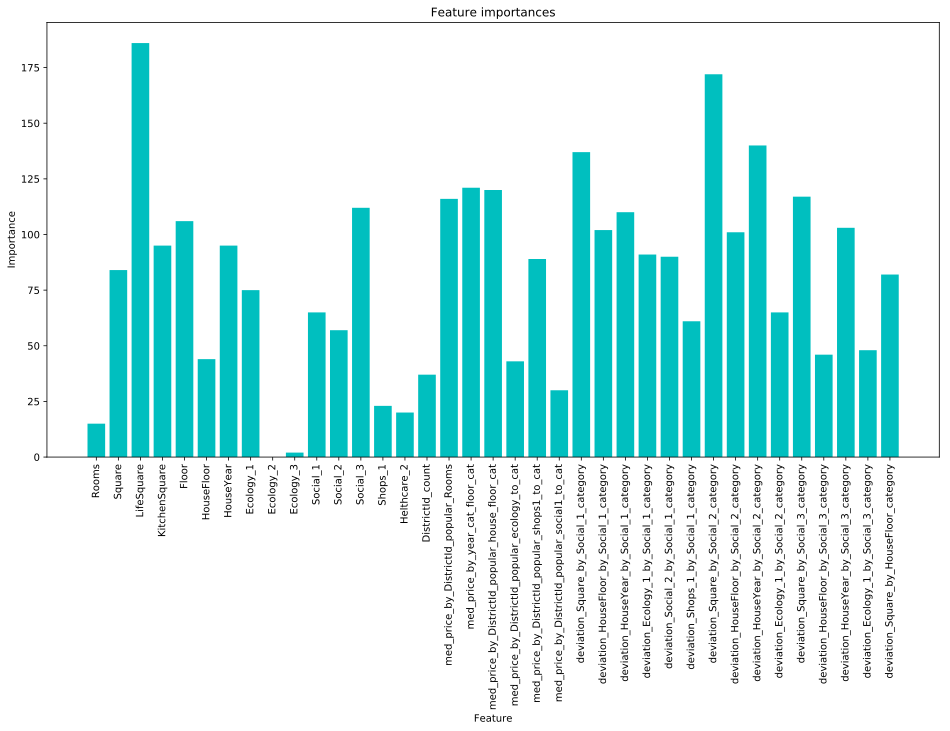

In [11]:
importances = model.feature_importances_
plt.figure(figsize = [16, 8])
plt.bar(X.columns, importances, color='c')
plt.title('Feature importances')
plt.xlabel('Feature')
plt.xticks(rotation = 90)
plt.ylabel('Importance')
plt.show()

**Предсказание на тесте**

In [12]:
y_pred_final = model.predict(X_final)

preds_final['Price'] = y_pred_final
preds_final.to_csv('predictions.csv', index=False)

preds_final.head()

,Id,Price
0,725,156595.739741
1,15856,253611.281477
2,5480,239721.514613
3,15664,340749.373049
4,14275,132661.233029


In [13]:
preds_final.shape

(5000, 2)